# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data

In [2]:
# we will use pandas to read the csv 
df = pd.read_csv("./Data/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data dictionary
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

# Data Quality Checks

In [3]:
# First let us make categorical data be defined as categorical types
df.rename(columns = {'gender':'sex'}, inplace=True) # Rename the column
categorical_columns = ['id',
                       'sex',
                       'hypertension',
                       'heart_disease',
                       'ever_married',
                       'work_type',
                       'Residence_type',
                       'smoking_status',
                       'stroke']
for col in categorical_columns:
    df[col] = df[col].astype('category', copy=False)
df.dtypes

id                   category
sex                  category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke               category
dtype: object

In [4]:
# Now we will look at the descriptive statistics for the continuous variables
df.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


We notice that for age the minimum age is 0.08, this warrants inspection. Also a BMI of 97.6 makes may be unlikely.

In [5]:
# Let us find these records
df[(df['age']==0.8) | (df['bmi']==97.6)]

,id,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1317,30084,Male,0.8,0,0,No,children,Rural,98.67,17.5,Unknown,0
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
2630,61836,Female,0.8,0,0,No,children,Urban,106.59,15.5,Unknown,0
2801,760,Male,0.8,0,0,No,children,Urban,75.22,33.1,Unknown,0
3626,23360,Male,0.8,0,0,No,children,Rural,114.54,15.1,Unknown,0


Since there are multiple values of age 0.8, and they are designated as children, we can assume that these are not incorrect entries. However, the BMI of 97.6 is likely incorrect. In fact it is unlikely that someone has a BMI greater than 70.

In [6]:
# Drop the subject with BMI > 70
df = df[(df['bmi'] < 70)]

In [7]:
# Now let us look at the categorical variables
df.describe(include="category")

,id,sex,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,4905,4905,4905,4905,4905,4905,4905,4905,4905
unique,4905,3,2,2,2,5,2,4,2
top,72940,Female,0,0,Yes,Private,Urban,never smoked,0
freq,1,2896,4457,4662,3202,2807,2489,1850,4696


We can see that we have 3 unique categories for sex. Let us inspect that first. 

In [8]:
df.groupby("sex")["id"].count()

sex
Female    2896
Male      2008
Other        1
Name: id, dtype: int64

So we have a third group of 'other', which only has 1 entry. let us explore the work_type and smoking_status variables next

In [9]:
df.groupby("work_type")["id"].count()

work_type
Govt_job          630
Never_worked       22
Private          2807
Self-employed     775
children          671
Name: id, dtype: int64

In [10]:
df.groupby("smoking_status")["id"].count()

smoking_status
Unknown            1482
formerly smoked     837
never smoked       1850
smokes              736
Name: id, dtype: int64

All of these variables look okay. Now let us check for missing data.

In [11]:
df.isna().sum()

id                   0
sex                  0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

So this data set, from KAGGLE, looks like it was already cleaned, we have no missing data.

# Assess feature quality

In [12]:
# Correlation matrix for the continuous variables. 
df.corr()

,age,avg_glucose_level,bmi
age,1.000000,0.235690,0.344499
avg_glucose_level,0.235690,1.000000,0.181491
bmi,0.344499,0.181491,1.000000


Looks like there is an association between age and bmi. As well as between age an average glucose levels. And maybe a week association between bmi and average glucose levels. 

In [13]:
# Look at stroke occurence for categorical variables (we can use a chi square test to test for significance if we want)
df.groupby(["sex", 'stroke'])['id'].count()

sex     stroke
Female  0         2776
        1          120
Male    0         1919
        1           89
Other   0            1
        1            0
Name: id, dtype: int64

In [14]:
df.groupby(["hypertension", 'stroke'])['id'].count()

hypertension  stroke
0             0         4308
              1          149
1             0          388
              1           60
Name: id, dtype: int64

In [15]:
df.groupby(["heart_disease", 'stroke'])['id'].count()

heart_disease  stroke
0              0         4493
               1          169
1              0          203
               1           40
Name: id, dtype: int64

In [16]:
df.groupby(["ever_married", 'stroke'])['id'].count()

ever_married  stroke
No            0         1680
              1           23
Yes           0         3016
              1          186
Name: id, dtype: int64

In [17]:
df.groupby(["work_type", 'stroke'])['id'].count()

work_type      stroke
Govt_job       0          602
               1           28
Never_worked   0           22
               1            0
Private        0         2680
               1          127
Self-employed  0          722
               1           53
children       0          670
               1            1
Name: id, dtype: int64

In [18]:
df.groupby(["Residence_type", 'stroke'])['id'].count()

Residence_type  stroke
Rural           0         2316
                1          100
Urban           0         2380
                1          109
Name: id, dtype: int64

In [19]:
df.groupby(["smoking_status", 'stroke'])['id'].count()

smoking_status   stroke
Unknown          0         1453
                 1           29
formerly smoked  0          780
                 1           57
never smoked     0         1766
                 1           84
smokes           0          697
                 1           39
Name: id, dtype: int64

# Visualization

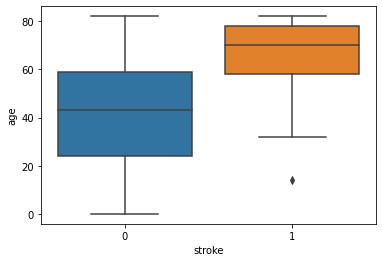

In [20]:
ax = sns.boxplot(y = "age", x = "stroke", data=df )

Looks like, on average, older individuals are more prone to having a stroke

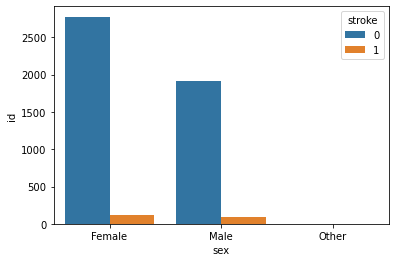

In [21]:
ax = sns.barplot(x = df.groupby(['sex','stroke'])['id'].count().reset_index()['sex'],
                 y = df.groupby(['sex','stroke'])['id'].count().reset_index()['id'],
                 hue = df.groupby(['sex','stroke'])['id'].count().reset_index()['stroke'])

In [22]:
df.groupby(['sex','stroke'])['id'].count().reset_index()

,sex,stroke,id
0,Female,0,2776
1,Female,1,120
2,Male,0,1919
3,Male,1,89
4,Other,0,1
5,Other,1,0


Considering the ratio of females to males is larger, it seems that males are more likely to have a stroke. 

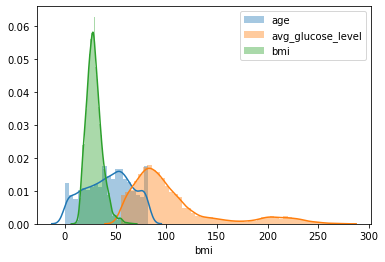

In [23]:
label = []
for col in df.columns:
    if df[col].dtype == float:
        label.append(str(col))
        sns.distplot(df[col])
        plt.legend(labels=label)

Average glucose level looks skewed, and the ranges of the features seem to be on different scales. We might need to scale and center the values depending on the algorithm we choose to use. 

In [24]:
# Export cleaned data set
df.to_csv("./Data/cleaned_data.csv", index=False)